# 06 - Doc2Vec
This notebook explores the governance data set using Doc2Vec. Doc2vec might be a good fit for our project as dimensionality reducer.

This code is largely based on [Document-Clustering-Doc2vec](https://github.com/aniketbote/Document-Clustering-Doc2vec/blob/master/Clustering/Clustering_code_Doc2Vec/clustering_Documents_Doc2Vec.py) by [Aniket Bote](https://github.com/aniketbote). We did remove the fixed seed for the randomizer.

Further reading [A gentle introduction to Doc2Vec](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e) by [Gidi Shperber](https://medium.com/@gidishperber) or [Doc2Vec — Computing Similarity between Documents](https://medium.com/red-buffer/doc2vec-computing-similarity-between-the-documents-47daf6c828cd) by [Abdul Hafeez Fahad](https://medium.com/@a.h.fahad18).


** Kaartje met clusters over gemeenten, dus voor zowel LSA and Doc2Vec een kaartje genereren welke gemeenten in welk cluster zitten
XXX **

---
## Dependencies and Imports
This section deals with fulfilling depenencies and installing the right packages for use in the code below.

Something to keep in mind is that a lot of sample code out there uses Gensum version 3, where we use the current-as-of-this-writing Gensim version 4. The API has changed quite a bit between versions 3 and 4 and sample code may need to be refactored to use the new API before it works. Most changes are in the naming and will cause run-time errors, so finding problems is easy.

In [1]:
!pip install gensim fastparquet scikit-learn matplotlib wordcloud

In [2]:
import re
import sys
from pathlib import Path
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'
GZIP='gzip'

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import __version__ as gensim__version__
print(f"gensim=={gensim__version__}")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

from wordcloud import WordCloud
from wordcloud import __version__ as wordcloud__version__
print(f"wordcloud=={wordcloud__version__}")

from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")
from sklearn.feature_extraction.text import TfidfVectorizer


python==3.11.4
pandas==2.0.2
gensim==4.3.1
scikit-learn==1.2.2
matplotlib==3.7.1
wordcloud==1.9.2
scikit-learn==1.2.2


---
## Load DV Data Set
This loads the DV data set. We first load as a Panda, because we have the code. Then we make the resultant `corpus` into the list of tagged documents that Gensim is designed to work with.

We also load the municipalities evaluation set. We will use that after clustering with the intention to be able to relate clusters to municipalities.

Finally, we load the document properties. These will help identify document classification issues by looking at the titles.

Spoiler alert, one of the results of outlier detection on our clustering revealed that some documents were misclassified.
The documents below are tagged as duurzaamheidvisie, but are really budget plans.

We found these as visible outliers in on of the clusters. Here we retrieve them by document title. Based on the earlier clustering run we now know what to look for.

In [3]:
DOCUMENT_ID = 'DocID'
DOCUMENT_TITLE = 'Titel'
JAAR = 'Jaar'

documents = pd.read_csv("../data/Governance/Duurzaamheidsvisies.csv", index_col=DOCUMENT_ID)
documents[JAAR] = documents[JAAR].astype(STRING).str.slice(0, 4)

documents[documents[DOCUMENT_TITLE].str.contains("egrot")]


,Titel,Jaar
DocID,,
GM0331DV01,Programmabegroting 2016,2015
GM0852DV01,Programmabegroting 2016,2016
GM0981DV01,Programma begroting 2016,2015


In [4]:
CACHE_DIR = '../cache/Governance'

# The Parquet files, gzipped.
ALL_PARQUET_GZ = CACHE_DIR + '/ALL_documents.parquet.gz'
DV_PARQUET_GZ  = CACHE_DIR + '/DV_documents.parquet.gz'

DV_corpus  = pd.read_parquet(DV_PARQUET_GZ)
ALL_corpus = pd.read_parquet(ALL_PARQUET_GZ)

# columns ofthe data set
DOCUMENT_BODY = 'body'
DOCUMENT_TITLE = 'Titel'
DOCUMENT_JAAR = 'Jaar'
MUNICIPALITY_CODE='GM_CODE'

corpus = DV_corpus
corpus.head()

,body,GM_CODE,Titel,Jaar
index,,,,
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...,GM0003,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...,GM0005,Milieubeleidsplan 2009-2012,2009
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...,GM0007,Milieubeleidsprogramma 2007-2015,2007
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...,GM0009,Duurzaamheidsvisie 2016-2018,2016
GM0034DV01,verseonnr dagmail december raad gemeente almer...,GM0034,Plan van aanpak duurzaamheidsagenda,2010


In [5]:
def make_into_tagged_documents(series):
    return [TaggedDocument(doc.split(' '), [i]) for i, doc in series.items()]

In [6]:
all_content = make_into_tagged_documents(corpus[DOCUMENT_BODY])
for i in range(5):
    print(f"{all_content[i].tags[0]}: {all_content[i].words[:5]}".replace("]", " ..."))

GM0003DV02: ['duurzaamheidsbeleid', 'Appingedam', 'duurzaamheidsbeleid', 'Appingedam', 'Inhoud' ...
GM0005DV01: ['colofon', 'gemeente', 'bedum', 'bezoekadres', 'Schoolstraat' ...
GM0007DV01: ['Milieubeleidsplan', 'vaststellen', 'gemeenteraad', 'bellingweden', 'maart' ...
GM0009DV01: ['inhoud', 'duurzaamheidsvisie', 'februari', 'inhoud', 'inhoud' ...
GM0034DV01: ['verseonnr', 'dagmail', 'december', 'raad', 'gemeente' ...


In [7]:
municipalities = pd.read_parquet("../data/CBS/Evaluation_data.parquet")
municipalities


,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,Windenergie_2021,Zonneenergie_2021,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat
index,,,,,,,,,,,,,,,,,,,
0,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
1,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,Veel,Veel,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder
2,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,Geen,Veel,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder
3,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,Beperkt,Veel,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder
4,GM0010,Delfzijl,Groningen,Klein,Arm,weinig stedelijk,Lokaal,Veel,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,GM1940,De Fryske Marren,Fryslân,Middelgroot,Modaal,weinig stedelijk,None,Gemiddeld,Veel,Veel,Gemiddeld,Gemiddeld,Gemiddeld,Middel,Laag,Middel,Middel,iets minder,meer
386,GM1942,Gooise Meren,Noord-Holland,Middelgroot,Rijk,sterk stedelijk,VVD,Geen,Beperkt,Geen,Beperkt,Geen,Beperkt,Hoog,Middel,Middel,Middel,veel lager,iets minder
387,GM1945,Berg en Dal,Gelderland,Middelgroot,Modaal,weinig stedelijk,Lokaal,Geen,Beperkt,Geen,Gemiddeld,Geen,Gemiddeld,Middel,Middel,Middel,Middel,iets minder,iets minder


---
## Train the Doc2Vec Model
With the data cleanly loaded, we can train the model. Since we are very much exploring and since training is relatively fast, we don't save the model. We simply retrain it every time.

One question that came up is whether we migth be overfitting. We have fewer than 300 documents, yet we train towards vectors of 300 dimensions. This is not a problem per se, as the training does not happen on individual documents, but rather on 5-grams of these documents. There are rather more than 300 5-grams.

Another topic we disucssed was whether 

In [8]:
d2v_model = Doc2Vec(all_content, vector_size=300, min_count=5, dm=0, alpha=0.0025, min_alpha=0.0001)
d2v_model.train(all_content, total_examples=d2v_model.corpus_count, epochs=50, start_alpha=0.002, end_alpha=-0.016)


---
## Elbow and Cluster with K-Means
We use the learned vectors to cluster the DV data set again using K-Means clustering. First we run K-Means clustering for different cluster sizes to make the elbow plot. Then we run K-Means to find the optimal number of clusters that we chose based on the elbow plot. We chose 5.


In [9]:
nc = range(1, 100)
kmeans = [KMeans(n_clusters = i, n_init = 100, max_iter = 500) for i in nc]               
score  = [kmeans[i].fit(d2v_model.dv.vectors).inertia_ for i in range(len(kmeans))]

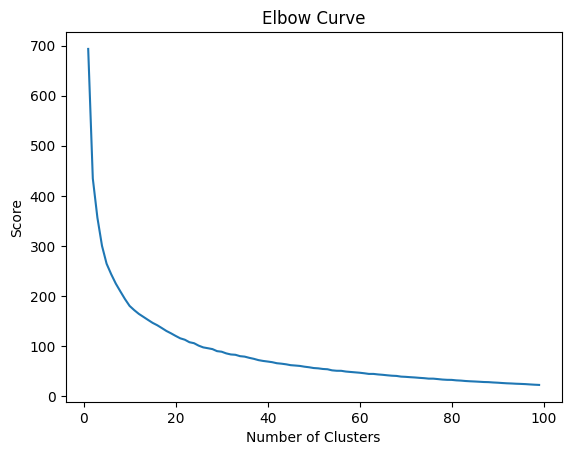

In [10]:
# Plot the elbow
plt.plot(nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [11]:
K_value = 5
kmeans_model = KMeans(n_clusters=K_value, n_init='auto') 
kmeans_model.fit(d2v_model.dv.vectors)

# XXX Where should I get clusters, from the model or as a result from predict()?
__clusters = kmeans_model.predict(d2v_model.dv.vectors)
labels = kmeans_model.labels_.tolist()


# // XXX add as dataframe

## Silhouette score
The silhouette score is a metric provided by scikit-learn that measures the quality of clustering results based on the average distance between samples within clusters and the average distance between samples in different clusters. It takes into account both the cohesion (how close samples are to each other within the same cluster) and the separation (how far samples are from samples in other clusters). The range is from -1 to 1.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [12]:
# Nog even checken bij Corné en Kees Jan of ze mijn gedachte kunnen volgen dat ik hier dv2 gebruik.
silhouette_avg = silhouette_score(d2v_model.dv.vectors, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.24960384


---
## PCA Analysis and Plotting
We use Principal Component Analysis (PCA) to flatten the 300-dimension document vectors onto a 2D shape for plotting. The banding in the graph below is an artefact of PCA, as the resulting components are not correlated.

In [13]:
# XXX Investigate precisely fit()/predict()/fit_predict().
# Which ones change the internal model state and have side effects?

__l = kmeans_model.fit_predict(d2v_model.dv.vectors)
pca = PCA(n_components=2).fit(d2v_model.dv.vectors)
datapoint = pca.transform(d2v_model.dv.vectors)

# // XXX add to data frame

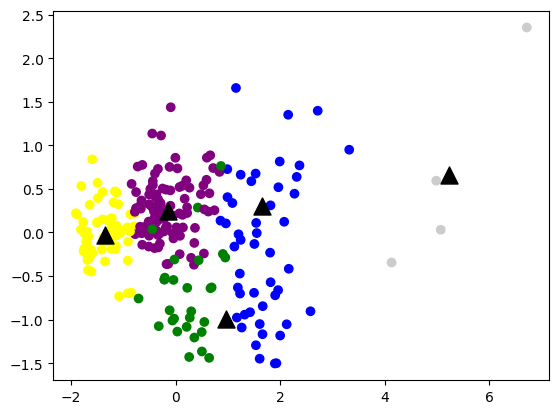

In [14]:
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#cccccc"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

# XXX print the document weigths for each document, sow we can identify them on the plot

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')

plt.show()


---
## Link to Municipality Data
This section three-way merges the clusters we found with the municipality data and document details for evaluation. Municipalities are indexed by their GM-code. Documents by their base file name.

In [15]:
CLUSTER='cluster'
MUNICIPALITY_ID='GM_Code'

kmeans_clusters = pd.DataFrame(index=corpus.index)
kmeans_clusters['DocID'] = corpus.index
kmeans_clusters[CLUSTER] = labels
kmeans_clusters[MUNICIPALITY_ID] = corpus.index.str.slice(0, 6)

kmeans_clusters.head()

,DocID,cluster,GM_Code
index,,,
GM0003DV02,GM0003DV02,3,GM0003
GM0005DV01,GM0005DV01,1,GM0005
GM0007DV01,GM0007DV01,1,GM0007
GM0009DV01,GM0009DV01,3,GM0009
GM0034DV01,GM0034DV01,3,GM0034


In [16]:
kmeans_clusters_with_municipalities = kmeans_clusters.merge(municipalities, how="left", on=MUNICIPALITY_ID).set_index('DocID')

# the merge adds suffixes to ensure unique column names, so we strip those off
# again since we have no name clashes.
kmeans_clusters_with_municipalities.columns=kmeans_clusters_with_municipalities.columns.str.rstrip('_x') 
kmeans_clusters_with_municipalities.head()


,cluster,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,Windenergie_2021,Zonneenergie_2021,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat
DocID,,,,,,,,,,,,,,,,,,,,
GM0003DV02,3,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
GM0005DV01,1,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,Veel,Veel,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder
GM0007DV01,1,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,Geen,Veel,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder
GM0009DV01,3,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,Beperkt,Veel,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder
GM0034DV01,3,GM0034,Almere,Flevoland,Groot,Modaal,sterk stedelijk,D66,Veel,Veel,Veel,Veel,Gemiddeld,Veel,Laag,Middel,Laag,Middel,meer,veel lager


In [17]:
kmeans_clusters_with_everything = kmeans_clusters_with_municipalities.join(documents)
kmeans_clusters_with_everything.head()



,cluster,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,...,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat,Titel,Jaar
DocID,,,,,,,,,,,,,,,,,,,,,
GM0003DV02,3,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,...,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0005DV01,1,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,...,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder,Milieubeleidsplan 2009-2012,2009
GM0007DV01,1,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,...,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder,Milieubeleidsprogramma 2007-2015,2007
GM0009DV01,3,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,...,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder,Duurzaamheidsvisie 2016-2018,2016
GM0034DV01,3,GM0034,Almere,Flevoland,Groot,Modaal,sterk stedelijk,D66,Veel,Veel,...,Gemiddeld,Veel,Laag,Middel,Laag,Middel,meer,veel lager,Plan van aanpak duurzaamheidsagenda,2010


In [18]:
kmeans_clusters_with_everything.to_parquet("../data/Governance/Doc2Vec_clusters.parquet")
kmeans_clusters_with_everything.loc[kmeans_clusters_with_everything[CLUSTER]==4, ['GM_Code', 'Gemeente', 'Titel', 'Jaar']]


,GM_Code,Gemeente,Titel,Jaar
DocID,,,,
GM0603DV01,GM0603,Rijswijk (ZH.),Groenbeleid deel 1,2010
GM0603DV02,GM0603,Rijswijk (ZH.),Groenbeleid deel 2,2010
GM0928DV01,GM0928,Kerkrade,Naar een duurzame vitale regio - regioprogramm...,2015
GM0986DV01,GM0986,Voerendaal,Parkstad Limburg Energietransitie Palet),<NA>


---
## Word Clouds and Word Lists
With the clustered established, we can now make word clouds of each of them. Before we can work with word clouds, we have to merge the K-Means clusters with the original corpus. The word clouds need the text.

In [19]:
corpus_with_cluster = corpus.join(kmeans_clusters)
corpus_with_cluster.head()


,body,GM_CODE,Titel,Jaar,DocID,cluster,GM_Code
index,,,,,,,
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...,GM0003,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011,GM0003DV02,3,GM0003
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...,GM0005,Milieubeleidsplan 2009-2012,2009,GM0005DV01,1,GM0005
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...,GM0007,Milieubeleidsprogramma 2007-2015,2007,GM0007DV01,1,GM0007
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...,GM0009,Duurzaamheidsvisie 2016-2018,2016,GM0009DV01,3,GM0009
GM0034DV01,verseonnr dagmail december raad gemeente almer...,GM0034,Plan van aanpak duurzaamheidsagenda,2010,GM0034DV01,3,GM0034


In [20]:
documents_with_cluster = corpus_with_cluster.iloc[:, 2:]
documents_with_cluster

,Titel,Jaar,DocID,cluster,GM_Code
index,,,,,
GM0003DV02,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011,GM0003DV02,3,GM0003
GM0005DV01,Milieubeleidsplan 2009-2012,2009,GM0005DV01,1,GM0005
GM0007DV01,Milieubeleidsprogramma 2007-2015,2007,GM0007DV01,1,GM0007
GM0009DV01,Duurzaamheidsvisie 2016-2018,2016,GM0009DV01,3,GM0009
GM0034DV01,Plan van aanpak duurzaamheidsagenda,2010,GM0034DV01,3,GM0034
...,...,...,...,...,...
GM1945DV01,Duurzaamheidsprogramma - Gemeente Berg en Dal,2013,GM1945DV01,2,GM1945
GM1955DV01,Milieuprogramma 2014,2014,GM1955DV01,1,GM1955
GM1955DV02,Zonne-energie in het buitengebied,0,GM1955DV02,0,GM1955


In [21]:
MIN_DF=15
MAX_DF=0.95
SUBLINEAR_TF=True

def document_bodies_in_cluster(corpus, cluster):
    return corpus[corpus[CLUSTER]==cluster][DOCUMENT_BODY]

def nlargest_of(corpus, cluster, n):
    docs = document_bodies_in_cluster(corpus, cluster)

    if len(docs) < MIN_DF:
        print(f"only {len(docs)} documents in cluster {cluster}, setting `min_df` and `max_df` system defaults")
        vectorizer = TfidfVectorizer(sublinear_tf=SUBLINEAR_TF)
    else:
        vectorizer = TfidfVectorizer(min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)

    counts = vectorizer.fit_transform(docs)
    totals = counts.sum(0)
    return pd.DataFrame(totals.T, index=vectorizer.get_feature_names_out())[0].nlargest(n)

def print_cluster(corpus, cluster):
    print(nlargest_of(corpus, cluster, 20))

def cloud_of_cluster(corpus, cluster):
    cloud = WordCloud(background_color="white", max_words=20).generate_from_frequencies(nlargest_of(corpus, cluster, 50))
    plt.axis('off')
    plt.imshow(cloud);


project             4.009102
gemeentelijk        3.631123
organisatie         3.326639
lokaal              3.306111
goed                3.220126
ontwikkeling        3.108060
moeten              3.107989
eur                 3.079957
energiebesparing    3.037931
inwoner             2.922423
gebouw              2.886697
rol                 2.839990
wij                 2.838323
stimuleren          2.832561
initiatief          2.821350
uitvoeren           2.817816
thema               2.797939
maatregel           2.783481
belangrijk          2.781903
woning              2.771208
Name: 0, dtype: float64


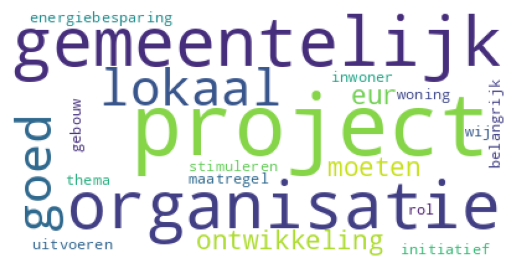

In [22]:
print_cluster(corpus_with_cluster, 0)
cloud_of_cluster(corpus_with_cluster, 0)


veiligheid              1.733657
regionaal               1.658761
afval                   1.646927
ambitie                 1.619229
taak                    1.590482
ver                     1.583608
water                   1.582680
milieubeleidsplan       1.548296
bodem                   1.546179
gebouw                  1.545739
geluid                  1.541918
jaarlijks               1.501604
programma               1.495889
natuur                  1.483620
milieubeleid            1.477120
uitvoeringsprogramma    1.475130
realiseren              1.461073
duurzaamheid            1.450710
afdeling                1.435277
één                     1.426776
Name: 0, dtype: float64


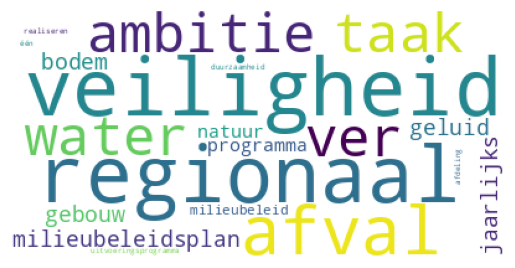

In [23]:
print_cluster(corpus_with_cluster, 1)
cloud_of_cluster(corpus_with_cluster, 1)


gebouw             1.901235
bouwen             1.782098
regionaal          1.778704
extern             1.745154
luchtkwaliteit     1.702053
veiligheid         1.696849
natuur             1.662549
bijlage            1.618562
verkeer            1.616484
programma          1.602255
maatschappelijk    1.570589
klimaat            1.546770
mobiliteit         1.542728
leefomgeving       1.534111
geluid             1.518427
elektrisch         1.517083
visie              1.508476
bodem              1.505500
wonen              1.502729
eur                1.496692
Name: 0, dtype: float64


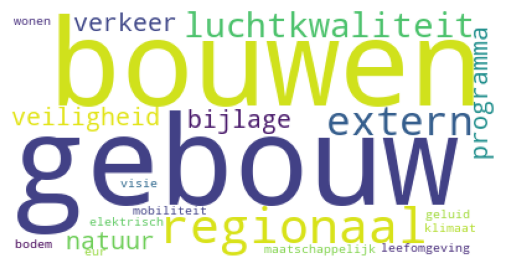

In [24]:
print_cluster(corpus_with_cluster, 2)
cloud_of_cluster(corpus_with_cluster, 2)


ambitie             3.565775
gebouw              3.564162
energiebesparing    3.470558
beleid              3.296202
doelstelling        3.287771
bouwen              3.286700
thema               3.154675
partij              3.104577
maatschappelijk     3.061959
kans                3.058422
milieu              3.058104
ruimte              3.052445
mobiliteit          3.050193
opstellen           3.025547
eur                 3.009340
water               2.987907
sociaal             2.980681
natuur              2.970521
vanuit              2.963211
wij                 2.955047
Name: 0, dtype: float64


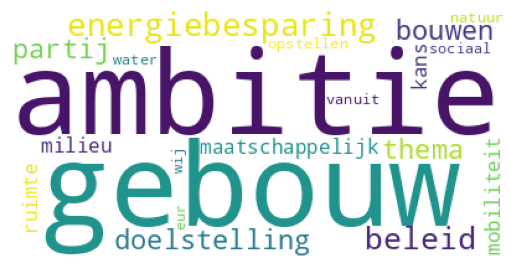

In [25]:
print_cluster(corpus_with_cluster, 3)
cloud_of_cluster(corpus_with_cluster, 3)


only 4 documents in cluster 4, setting `min_df` and `max_df` system defaults
rijswijk              0.154162
groen                 0.142416
gemeente              0.135484
gebied                0.128802
landgoederenzone      0.128153
groenbeleidsplan      0.128036
bomenatuurecreatie    0.127783
goed                  0.122976
groot                 0.122151
zullen                0.121192
belangrijk            0.119122
boomstructuur         0.116098
tussen                0.115677
per                   0.115482
liggen                0.115065
moeten                0.114370
woning                0.113850
stadsparkzone         0.113649
ander                 0.113195
stad                  0.112735
Name: 0, dtype: float64
only 4 documents in cluster 4, setting `min_df` and `max_df` system defaults


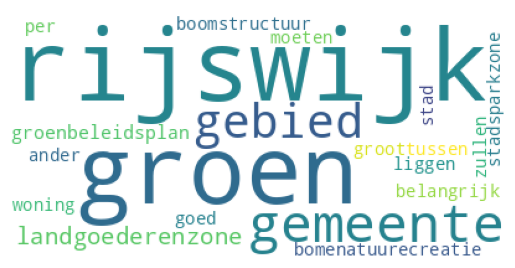

In [26]:
print_cluster(corpus_with_cluster, 4)
cloud_of_cluster(corpus_with_cluster, 4)


In [27]:
corpus_with_cluster[corpus_with_cluster[CLUSTER] == 3]

,body,GM_CODE,Titel,Jaar,DocID,cluster,GM_Code
index,,,,,,,
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...,GM0003,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011,GM0003DV02,3,GM0003
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...,GM0009,Duurzaamheidsvisie 2016-2018,2016,GM0009DV01,3,GM0009
GM0034DV01,verseonnr dagmail december raad gemeente almer...,GM0034,Plan van aanpak duurzaamheidsagenda,2010,GM0034DV01,3,GM0034
GM0034DV02,afspraak duurzaam alm versie mei algemeen acht...,GM0034,Afspraken Duurzaam Almere 2012-2014,2012,GM0034DV02,3,GM0034
GM0037DV02,nota duurzaam energie energiebesparing stadska...,GM0037,Nota Duurzame Energie en Energiebesparing Stad...,2010,GM0037DV02,3,GM0037
...,...,...,...,...,...,...,...
GM1783DV01,waardevol westland duurzaamheidsagenda waardev...,GM1783,Duurzaamheidsagenda 2012-2020 - Gemeente Westland,2012,GM1783DV01,3,GM1783
GM1883DV01,duurzaamheidsplan september Jos rooy sittard g...,GM1883,duurzaamheidsnota sittard-geleen 2012-2016,2012,GM1883DV01,3,GM1883
GM1900DV01,stap nei duorsumens duurzaamheidsvisie gemeent...,GM1900,Duurzaamheidsnota 2012,2012,GM1900DV01,3,GM1900


In [28]:
corpus_with_cluster[CLUSTER].value_counts().sort_index()

cluster
0    67
1    28
2    48
3    98
4     4
Name: count, dtype: int64

Van de vijf clusters is er een cluster met slechts 5 documenten. Dit cluster bevat duidelijk andere documenten dan duurzaamheidsvisies en milieuprogramma's. De twee documenten uit Rijswijk (GM0603) betreffen groenbeleidsplannen. Het document van Kerkrade (GM0928) is een toekomstvisie en heeft samen met de energievisie van Voerendaal (GM0986) betrekking op de Parkstad regio in Zuid-Limburg en clusteren daarom mogelijk samen.

De andere clusters zijn op basis van de belangrijkste te woorden te benoemen als (volgorde kan wisselen met de run van het notebook):
- energiebeleid
- milieubeleidsplannen
- duurzaamheidsbeleid
- afvalbeleid

---
## Redo Wordclouds, but Minus All Documents

We now redo the word clouds, but instead of looking at the word clouds for the clusters, we try to remove a layer of common words by subtracting the IDF of all documents. We did this before, as part of the "_01 - TF-IDF on the Governance Set_" notebook.

Let's first generate the TF-IDF components for all documents. This code is near-verbatim from the "_01..._" notebook.


In [29]:
def tfidf_vectorize(series, min_df, max_df, sublinear_tf):
    if len(series) < MIN_DF:
        print(f"only {len(series)} documents in cluster, setting `min_df` and `max_df` system defaults")
        vectorizer = TfidfVectorizer(sublinear_tf=SUBLINEAR_TF)
    else:
        vectorizer = TfidfVectorizer(min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)

    # run the vectorizer on the data
    word_matrix = vectorizer.fit_transform(series)
    words_list = vectorizer.get_feature_names_out()

    # take the output and package it into various useful data frames
    matrix = pd.DataFrame(index=series.index, columns=words_list, data=word_matrix.toarray())
    idf = pd.DataFrame(columns=words_list, data=[vectorizer.idf_])

    return matrix, idf


In [30]:
all_docs_matrix, _ = tfidf_vectorize(ALL_corpus[DOCUMENT_BODY], min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)

def cluster_vs_all_wordcloud(corpus_with_cluster, cluster, all_docs_matrix):
    cluster_docs_matrix, cluster_docs_idf = tfidf_vectorize(document_bodies_in_cluster(corpus_with_cluster, cluster), min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)
    
    unique_for_cluster = (cluster_docs_matrix.mean() - all_docs_matrix.mean()).dropna().sort_values()
    print(unique_for_cluster.nlargest(20))

    cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(unique_for_cluster)
    plt.axis('off')
    plt.imshow(cloud);


project             0.041659
energiebesparing    0.036152
lokaal              0.030307
organisatie         0.029666
gebouw              0.029350
thema               0.028817
ambitie             0.027193
maatregel           0.026886
rol                 0.026376
initiatief          0.026058
eur                 0.025111
stimuleren          0.025110
ontwikkeling        0.024960
woning              0.024886
actie               0.024703
voorbeeld           0.024575
doelstelling        0.024487
doel                0.024375
elektrisch          0.024277
energieneutraal     0.023981
dtype: float64


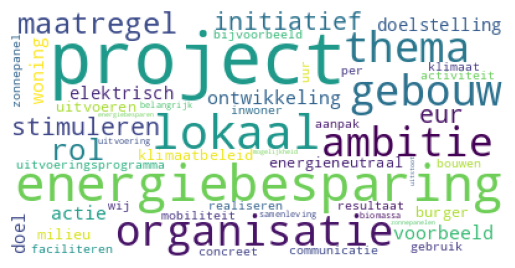

In [31]:
cluster_vs_all_wordcloud(corpus_with_cluster, 0, all_docs_matrix)


milieubeleidsplan       0.050606
geluid                  0.049140
bodem                   0.048155
milieubeleid            0.048054
afval                   0.046807
veiligheid              0.046768
water                   0.044581
ambitie                 0.044016
luchtkwaliteit          0.043263
uitvoeringsprogramma    0.042962
afdeling                0.041936
regionaal               0.041688
gebouw                  0.041470
milieubeheer            0.041182
natuur                  0.041000
taak                    0.040497
vergunningverlening     0.040400
jaarlijks               0.040126
vergunning              0.038661
klimaat                 0.038412
dtype: float64


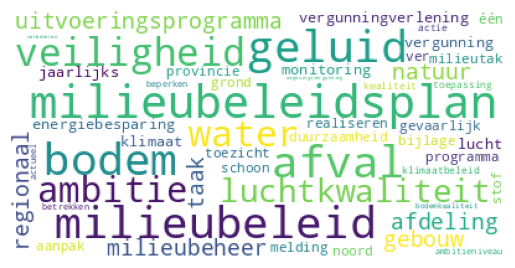

In [32]:
cluster_vs_all_wordcloud(corpus_with_cluster, 1, all_docs_matrix)


luchtkwaliteit       0.029715
gebouw               0.025874
geluid               0.025705
stof                 0.025596
klimaat              0.024383
bodem                0.024299
elektrisch           0.024277
extern               0.024227
scheiden             0.023823
bouwen               0.023442
energieverbruik      0.023292
mobiliteit           0.023253
natuur               0.022650
milieubeleidsplan    0.022488
auto                 0.022318
warmte               0.022015
schoon               0.021938
verkeer              0.021754
lucht                0.021720
gevaarlijk           0.021669
dtype: float64


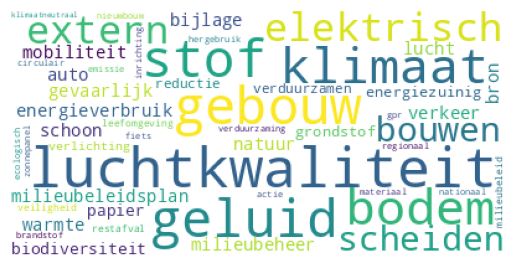

In [33]:
cluster_vs_all_wordcloud(corpus_with_cluster, 2, all_docs_matrix)


energiebesparing    0.026224
gebouw              0.022634
ambitie             0.022572
mobiliteit          0.022237
uitstoot            0.021147
elektrisch          0.021123
bouwen              0.019852
energieverbruik     0.019486
thema               0.019248
energieneutraal     0.019218
verduurzamen        0.019106
verlichting         0.018788
voorbeeld           0.018750
verduurzaming       0.018598
water               0.018545
natuur              0.018325
warmte              0.018074
biomassa            0.018056
doelstelling        0.017960
actie               0.017943
dtype: float64


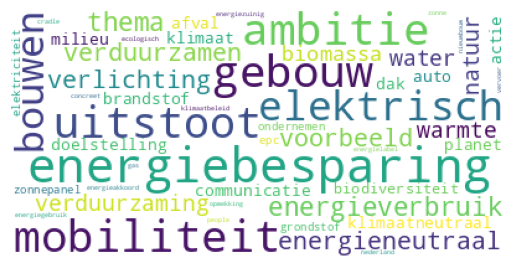

In [34]:
cluster_vs_all_wordcloud(corpus_with_cluster, 3, all_docs_matrix)


only 4 documents in cluster, setting `min_df` and `max_df` system defaults
rijswijk             0.037437
landgoederenzone     0.031533
groenbeleidsplan     0.029111
boomstructuur        0.027647
prinses              0.025772
wijkpark             0.025158
beatrixlaan          0.024932
bomenlaon            0.024015
deelgebied           0.023654
oever                0.022735
spoorlaan            0.021889
markant              0.021702
bloemrijk            0.021585
droog                0.021582
groenstructuur       0.021478
bomenrij             0.021453
vliet                0.021270
verbindingszones     0.021064
belevingswaaren      0.020954
natuurvriendelijk    0.020915
dtype: float64


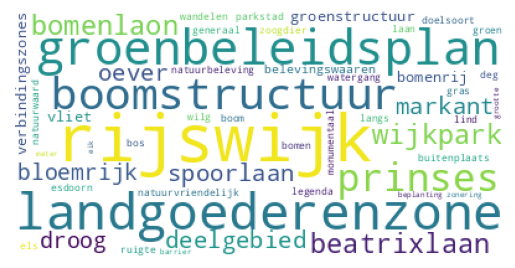

In [35]:
cluster_vs_all_wordcloud(corpus_with_cluster, 4, all_docs_matrix)
